# Plotting FRAP Data

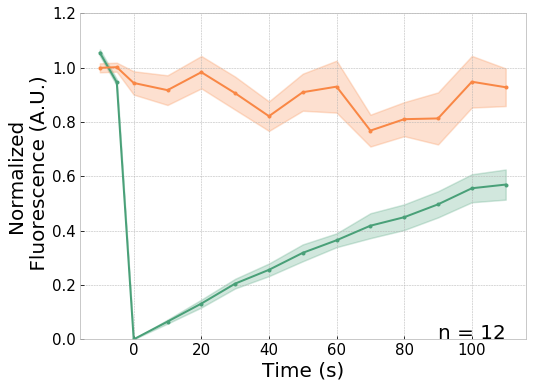

In [1]:
# Tells matplotlib to put plot in jupyter
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np
import random as rand 
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd

with plt.style.context('bmh'):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_subplot(1, 1, 1, facecolor = 'white')

    #font
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Arial']
    font_size = 20
    ax.set_xlabel('Time (s)', fontsize = font_size, color = 'black')
    ax.set_ylabel('Normalized\n Fluorescence (A.U.)', fontsize = font_size, color = 'black')
    #tick font
    label_size = 30
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    #legend
    # ax.plot(x, y, label = "Exp", color = 'steelblue')
    # ax.plot(x, z, label = "Control", color = 'orange')

    df = pd.read_excel('Example_bleached_pole.xlsx')
    dfc = pd.read_excel('Example_unbleached_pole.xlsx')
    x1 = dfc['Time']
    u = dfc['Unbleached Pole']
    v = dfc['Standard Error']
    w = df['Standard Error']
    x = df['Time']
    y = df['Bleached Pole']
 
    
    ax.plot(x , y , '.-', linewidth = 2, color = '#49a078')
    ax.plot(x1 , u, '.-', linewidth = 2, color = '#f98745')
#     ax.scatter(x , y, c = 'black' )

    plt.ylim(0,1.2)

#   Shade Standard error
    ax.fill_between(x, y - w, y + w, color = ('#49a078'), alpha = 0.25, edgecolor = 'black', linewidth = 1.5)
    ax.fill_between(x1 , u - v, u + v, color = ('#f98745'), alpha = 0.25, edgecolor = 'black', linewidth = 1.5 )
    
#     lgd = ax.legend(loc= (1,0.8675), frameon=True, fontsize = font_size/1.5, facecolor = 'white', framealpha = 0.5)
    
    ax.text(90, 0, "n = 12", fontsize = font_size)
    


#     plt.savefig('Example.svg', format = 'svg', dpi = 1200)

# Experimental (Bleached pole curve fit)
### Here's the procedure:
1. Load the data
2. Define a function for curve fitting
3. Fit the curve
4. Plot the data to make sure it fits well

In [2]:
# Import necessary packages

import seaborn as sns  # Since we're working with dataframes, this will make our visualization process easier
from scipy import optimize, stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [3]:
  # I made this function to help with the plotting

def tsplot(df, mean='mean', sem='sem', Fit='Fit', xlab='Time(s)', ylab='Normalized Fluorescence (A.U)', legend=True, color="#49a078"):
    """
    Make a nice timeseries plot
    """
    fig = plt.figure(figsize = (9, 6))
    ax = fig.add_subplot(1, 1, 1, facecolor = 'white')
    m = df[mean]
    s = df[sem]
    ax.plot(df.index, m, ".-", lw=2, c=color, label=mean)
    ax.fill_between(df.index, m - s, m + s, color=color, alpha = 0.25, lw=0, label=sem)
    ax.set_xlabel(xlab, fontsize = 16)
    ax.set_ylabel(ylab, fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    if Fit in df.columns:
        ax.plot(df.index, df[Fit], "k--", alpha = 0.75, lw=2, label=Fit)
        
        ax.text(75, 0.1, '$t$$_1$$_/$$_2$ = {} s\n $R$$^2$ = {} '.format(t_half_2dec, r2_2dec),  fontsize = font_size/1.3)
        
    if legend:
        ax.legend(loc='best', fontsize = 12)
#     plt.savefig('Example_fit.svg', format = 'svg', dpi = 1200)

    return ax

def get_stats(df):
    # Unfortunately the "agg" function isn't very flexible, so we have to transpose the data twice
    return df.T.agg(['mean', 'sem']).T

### Load the Data

Read the excel file and display the output so we know what we're working with here

In [4]:
# This is a relative path so it's different on my machine
excel_path = 'Example_bleached_pole.xlsx'
raw_data = pd.read_excel(excel_path)

# I'm going to set the index as Time. Just to make display easier for the "time" being. Ha ha.
raw_data.set_index('Time', inplace=True)
display(raw_data)

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12,Bleached Pole,Standard Error
Time,,,,,,,,,,,,,,
-10.0,1.083346,1.021896,1.019046,1.109028,1.130260,1.009869,1.051824,1.080900,1.033486,1.069561,0.999496,1.047191,1.054659,0.011777
-5.0,0.916654,0.978104,0.980954,0.890972,0.869740,0.990131,0.948176,0.919100,0.966514,0.930439,1.000504,0.952809,0.945341,0.011777
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.060369,0.081021,0.081364,0.069435,0.042139,0.049867,0.089397,0.020506,0.026293,0.088456,0.084524,0.087551,0.065077,0.007193
20.0,0.119312,0.107696,0.104905,0.155652,0.052224,0.146580,0.213706,0.099992,0.075530,0.137666,0.220030,0.143223,0.131376,0.014411
30.0,0.146193,0.174453,0.149118,0.221194,0.133021,0.240917,0.344698,0.164088,0.166749,0.248386,0.250775,0.218364,0.204830,0.017636
40.0,0.190794,0.201697,0.175484,0.233123,0.196650,0.313784,0.422025,0.196323,0.200732,0.290840,0.374764,0.271304,0.255627,0.023159
50.0,0.275642,0.289708,0.181947,0.257021,0.293715,0.376259,0.548312,0.228101,0.308446,0.411026,0.441546,0.205840,0.318130,0.030960
60.0,0.391050,0.286855,0.252996,0.259030,0.292214,0.407275,0.487487,0.394185,0.376287,0.465240,0.482876,0.277680,0.364431,0.025404


### Let's make a pretty data frame to make things easier
We're going to ignore the columns you calculated in excel for now and use them to make sure all calculations are correct

In [5]:
# Here I use a nested list comprehension to only select columns that have an underscore
# This effectively ignores the columns "Bleached Pole" and "Standard Error"
data = raw_data.loc[:, [c for c in raw_data.columns if ("_" in c)]]
# data

Here's a look at the data. It looks like what we expect

** Note: ** seaborn doesn't natively plot standard error, so I did the standard deviation which is directly proporitional. You can ignore the deprecation warning

In [6]:
data

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12
Time,,,,,,,,,,,,
-10.0,1.083346,1.021896,1.019046,1.109028,1.130260,1.009869,1.051824,1.080900,1.033486,1.069561,0.999496,1.047191
-5.0,0.916654,0.978104,0.980954,0.890972,0.869740,0.990131,0.948176,0.919100,0.966514,0.930439,1.000504,0.952809
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.060369,0.081021,0.081364,0.069435,0.042139,0.049867,0.089397,0.020506,0.026293,0.088456,0.084524,0.087551
20.0,0.119312,0.107696,0.104905,0.155652,0.052224,0.146580,0.213706,0.099992,0.075530,0.137666,0.220030,0.143223
30.0,0.146193,0.174453,0.149118,0.221194,0.133021,0.240917,0.344698,0.164088,0.166749,0.248386,0.250775,0.218364
40.0,0.190794,0.201697,0.175484,0.233123,0.196650,0.313784,0.422025,0.196323,0.200732,0.290840,0.374764,0.271304
50.0,0.275642,0.289708,0.181947,0.257021,0.293715,0.376259,0.548312,0.228101,0.308446,0.411026,0.441546,0.205840
60.0,0.391050,0.286855,0.252996,0.259030,0.292214,0.407275,0.487487,0.394185,0.376287,0.465240,0.482876,0.277680


In [7]:
# Make a dataframe of the statistics.

all_stats = get_stats(data)
all_stats

,mean,sem
-10.0,1.054659,0.011777
-5.0,0.945341,0.011777
0.0,0.000000,0.000000
10.0,0.065077,0.007193
20.0,0.131376,0.014411
30.0,0.204830,0.017636
40.0,0.255627,0.023159
50.0,0.318130,0.030960
60.0,0.364431,0.025404
70.0,0.417927,0.045777


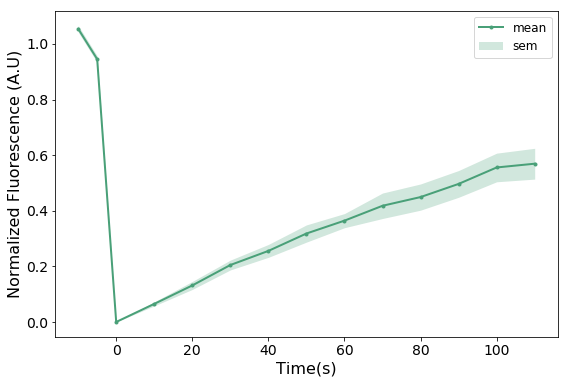

In [8]:
ax = tsplot(all_stats)

In [9]:
# We'll also filter out the times we don't need by only taking positive times
curve_data = data.loc[data.index >=0]

# So pretty!
display(curve_data.head())
curve_stats = get_stats(curve_data)
display(curve_stats)

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12
Time,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.060369,0.081021,0.081364,0.069435,0.042139,0.049867,0.089397,0.020506,0.026293,0.088456,0.084524,0.087551
20.0,0.119312,0.107696,0.104905,0.155652,0.052224,0.146580,0.213706,0.099992,0.075530,0.137666,0.220030,0.143223
30.0,0.146193,0.174453,0.149118,0.221194,0.133021,0.240917,0.344698,0.164088,0.166749,0.248386,0.250775,0.218364
40.0,0.190794,0.201697,0.175484,0.233123,0.196650,0.313784,0.422025,0.196323,0.200732,0.290840,0.374764,0.271304


,mean,sem
0.0,0.000000,0.000000
10.0,0.065077,0.007193
20.0,0.131376,0.014411
30.0,0.204830,0.017636
40.0,0.255627,0.023159
50.0,0.318130,0.030960
60.0,0.364431,0.025404
70.0,0.417927,0.045777
80.0,0.449252,0.047136
90.0,0.496562,0.048114


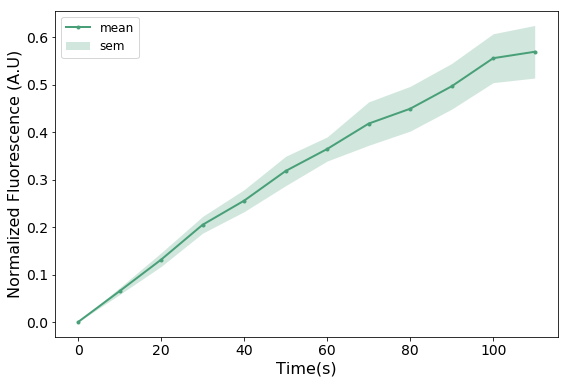

In [10]:
ax = tsplot(curve_stats)

#### If you want to ignore the times where there are NaNs, uncomment this line, but statistically you can probably keep them
If you do drop the NaN times, you will get different parameters

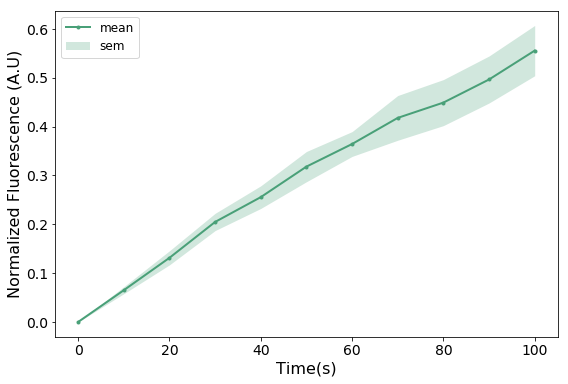

In [11]:
#Need to drop NaN because that frame was all noise during acquisition
curve_stats = get_stats(curve_data.dropna())
ax = tsplot(curve_stats)

## Let's fit a curve!

I used the function from __[this presentation](https://www.embl.de/eamnet/downloads/courses/FRAP2004/frap_intro_miura.pdf)__ (Slide 12).

In [12]:
def f(t, a, tau):
    """
    :param t: array; x-values, usually time
    :param a: float; mobile fraction
    :param tau: float; exponential constant. related to half max time
    :return: float
    """
    return a*(1-np.exp(-tau*t))

In [13]:
popt, pcov = optimize.curve_fit(f, curve_stats.index, curve_stats['mean'])

# Popt is a tuple of the parameters A (the mobile fraction) and tau, which is related to the recover halflife
A, tau = popt
t_half = np.log(0.5)/-tau
popt

/Users/jfinkle/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


array([1.23916849, 0.00580583])

In [14]:
# Calculate the predicted values
p = f(curve_stats.index.values, *popt)
"""
Note my use of *popt. My function "f" defined above takes 3 arguments. popt is a tuple of length 2. The * syntax
unpacks the tuple as the rest of the arguments of the function

Because I explicitly unpacked them earlier in the line "A, tau = popt" this is equivalent to
p = f(curve_stats.index.values, A, tau)
"""

'\nNote my use of *popt. My function "f" defined above takes 3 arguments. popt is a tuple of length 2. The * syntax\nunpacks the tuple as the rest of the arguments of the function\n\nBecause I explicitly unpacked them earlier in the line "A, tau = popt" this is equivalent to\np = f(curve_stats.index.values, A, tau)\n'

In [15]:
# The correlation looks pretty good
r2 = metrics.r2_score(curve_stats['mean'], f(curve_stats.index.values, *popt))
print(r2)
r2_float = float(r2)
r2_2dec = '{0:.3f}'.format(r2_float)

0.998708891023479


In [16]:
# Print the values
print("A: {}, \ntau: {}, \nt_half: {}, \nhalf_max: {}".format(A, tau, t_half, f(t_half, A, tau)))

A: 1.2391684906226956, 
tau: 0.0058058257483503935, 
t_half: 119.38821635439005, 
half_max: 0.6195842453113478


In [17]:
t_half_float = float(t_half)

In [18]:
t_half_2dec = '{0:.2f}'.format(t_half_float)

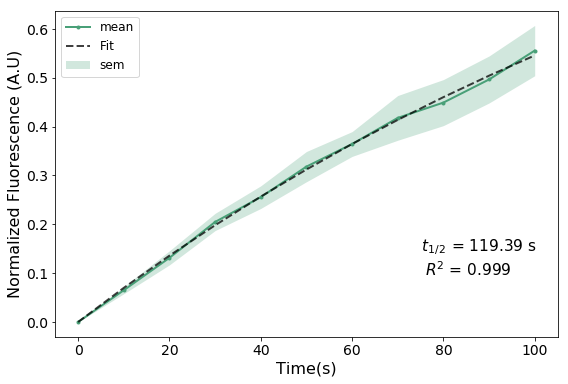

In [19]:
## I don't understand how this works. Does this add a column 'prediction' to the curve_stats data frame?
# Let's add the prediction to the plot
curve_stats['Fit'] = p
tsplot(curve_stats)